<a href="https://colab.research.google.com/github/arutraj/ML_Basics/blob/main/CV_3__P2__Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTANT: **It is highly recommended that this notebook be run on Google Colab itself as it contains CUDA usage, which may not be supported in the local environment of some computers.

In [1]:
import os

local_assets_b = False

if local_assets_b:
  assets_dir = "/content/assets/P2/"

  if not os.path.isdir(assets_dir):
    assert os.path.isfile("assets.zip")
    os.system("unzip assets.zip")
else:
  #assets_dir = '/content/drive/MyDrive/CV-3/Live Class Slides & Notebooks/assets/P2/'
  assets_dir= "https://drive.google.com/drive/folders/19T0Z3uChMivhiQLJ9h_nN8HRIsAIHDCN"

In [2]:
assets_dir

'https://drive.google.com/drive/folders/19T0Z3uChMivhiQLJ9h_nN8HRIsAIHDCN'

### Imports

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from pprint import pprint
from torch.utils.data import DataLoader

In [4]:
import torchvision
from torchvision.transforms import functional as F
from PIL import Image
import numpy as np
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [5]:
!gdown 1Q1MMb57NFdip4HtW3RW7jMDGK4qj9yxi

Downloading...
From (original): https://drive.google.com/uc?id=1Q1MMb57NFdip4HtW3RW7jMDGK4qj9yxi
From (redirected): https://drive.google.com/uc?id=1Q1MMb57NFdip4HtW3RW7jMDGK4qj9yxi&confirm=t&uuid=3d5b4253-7f8a-46d2-aafe-a36cf910344c
To: /content/PennFudanPed.zip
100% 54.0M/54.0M [00:03<00:00, 17.0MB/s]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

source_path = "/content/PennFudanPed.zip"
# assets_dir + "PennFudanPed.zip"
destination_dir = "/content/Pedestrian/"
!unzip "{source_path}" -d {destination_dir}

Mounted at /content/drive
Archive:  /content/PennFudanPed.zip
   creating: /content/Pedestrian/PennFudanPed/
  inflating: /content/Pedestrian/__MACOSX/._PennFudanPed  
   creating: /content/Pedestrian/PennFudanPed/PedMasks/
  inflating: /content/Pedestrian/__MACOSX/PennFudanPed/._PedMasks  
  inflating: /content/Pedestrian/PennFudanPed/.DS_Store  
  inflating: /content/Pedestrian/__MACOSX/PennFudanPed/._.DS_Store  
  inflating: /content/Pedestrian/PennFudanPed/added-object-list.txt  
  inflating: /content/Pedestrian/__MACOSX/PennFudanPed/._added-object-list.txt  
   creating: /content/Pedestrian/PennFudanPed/Annotation/
  inflating: /content/Pedestrian/__MACOSX/PennFudanPed/._Annotation  
   creating: /content/Pedestrian/PennFudanPed/PNGImages/
  inflating: /content/Pedestrian/__MACOSX/PennFudanPed/._PNGImages  
  inflating: /content/Pedestrian/PennFudanPed/readme.txt  
  inflating: /content/Pedestrian/__MACOSX/PennFudanPed/._readme.txt  
  inflating: /content/Pedestrian/PennFudanPed/P

### About the Dataset

The Penn-Fudan Database for Pedestrian Detection and Segmentation is an image database containing images that are used for pedestrian detection in the experiments reported in research papers. The images are taken from scenes around campus and urban streets, and the objects of interest in these images are pedestrians. Each image will have at least one pedestrian in it, and the heights of labeled pedestrians in this database fall into [180, 390] pixels. All labeled pedestrians are straight up. There are 170 images with 345 labeled pedestrians, among which 96 images are taken from around the University of Pennsylvania, and the other 74 are taken from around Fudan University. The Penn-Fudan Database is used by researchers to develop and evaluate algorithms for pedestrian detection and segmentation.

In [7]:
class PedestrianDataset(torch.utils.data.Dataset):
    def __init__(self , images , masks, imgs_path, masks_path):
        self.imgs = images
        self.masks = masks
        self.imgs_path = imgs_path
        self.masks_path = masks_path

    def __getitem__(self , idx):
        img = Image.open(self.imgs_path + "/" + self.imgs[idx]).convert("RGB")
        mask = Image.open(self.masks_path + "/" + self.masks[idx])
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            masks[i][mask == i+1] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)
        image_id = torch.as_tensor(idx , dtype = torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        return T.ToTensor()(img) , target

    def __len__(self):
        return len(self.imgs)

### Dataset

Datasets are the collections of your training, validation, and test data. They consist of input samples and their corresponding target labels (for supervised learning). In PyTorch, datasets are typically created using custom classes inheriting from `torch.utils.data.Dataset`. You load your data into this class, allowing easy access during training. PyTorch provides built-in datasets like MNIST, CIFAR-10, and ImageNet, but custom datasets can also be created to work with specific data.

In [8]:
images_path = "/content/Pedestrian/PennFudanPed/PNGImages/"
masks_path = "/content/Pedestrian/PennFudanPed/PedMasks/"

In [9]:
images = sorted(os.listdir(images_path))
masks = sorted(os.listdir(masks_path))

num = int(0.9 * len(images))
num = num if num % 2 == 0 else num + 1

train_imgs_indices = np.random.choice(range(len(images)) , num , replace = False)
val_imgs_indices = np.setdiff1d(range(len(images)) , train_imgs_indices)

train_imgs = np.array(images)[train_imgs_indices]
val_imgs = np.array(images)[val_imgs_indices]

train_masks = np.array(masks)[train_imgs_indices]
val_masks = np.array(masks)[val_imgs_indices]

In [10]:
train_dataset = PedestrianDataset(train_imgs, train_masks, images_path, masks_path)
valid_dataset = PedestrianDataset(val_imgs, val_masks, images_path, masks_path)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")

Train size: 154
Valid size: 16


### Dataloaders

Dataloaders, are utilities that enable efficient data loading and batching. They take a dataset as input and allow users to define batch sizes, shuffle the data, and apply transformations to the samples. Dataloaders are especially useful when dealing with large datasets, as they enable the model to process data in small batches, reducing memory requirements and speeding up training. They are key components in PyTorch that facilitate data handling and preparation for machine learning tasks.

In [11]:
def custom_collate(data):
  return data

In [12]:
n_cpu = os.cpu_count()

train_dataloader = DataLoader(train_dataset,
                              batch_size = 2,
                              shuffle = True,
                              num_workers = n_cpu,
                              collate_fn = custom_collate,
                              pin_memory = True if torch.cuda.is_available() else False)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size = 2,
                              shuffle = False,
                              num_workers = n_cpu,
                              collate_fn = custom_collate,
                              pin_memory = True if torch.cuda.is_available() else False)

### Plotting some images from the Dataset

In [13]:
idx = 0
img = Image.open(images_path + images[idx]).convert("RGB")
mask = Image.open(masks_path + masks[idx])

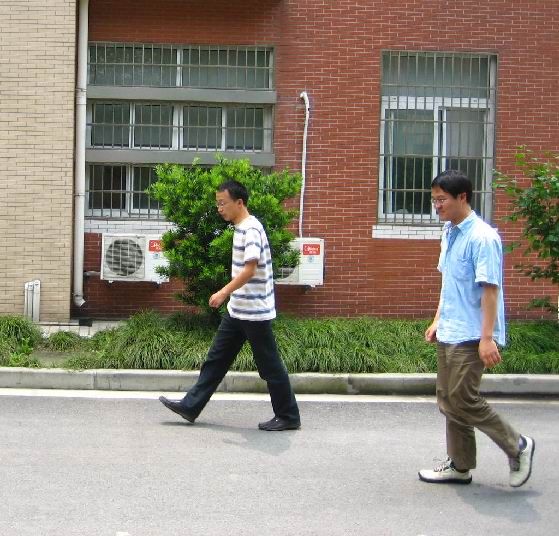

In [14]:
img

In [15]:
np.unique(mask)

array([0, 1, 2], dtype=uint8)

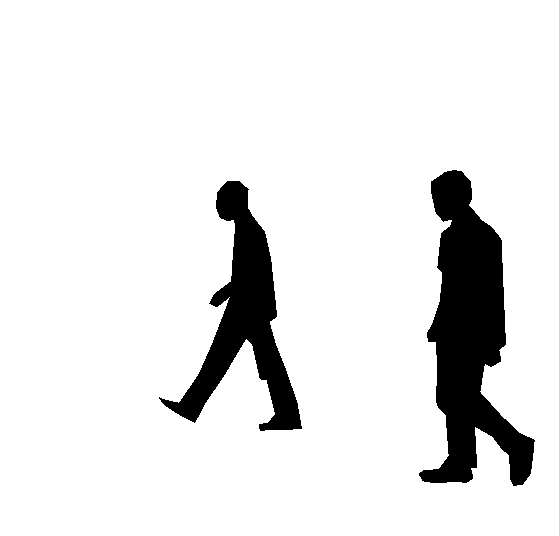

In [16]:
Image.fromarray(np.array(mask) == 0)

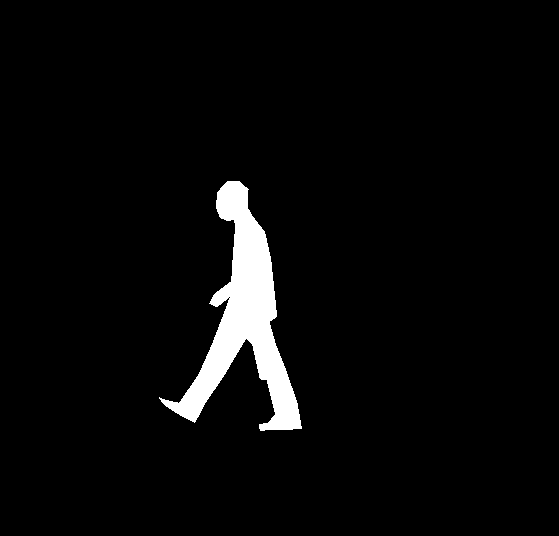

In [17]:
Image.fromarray(np.array(mask) == 1)

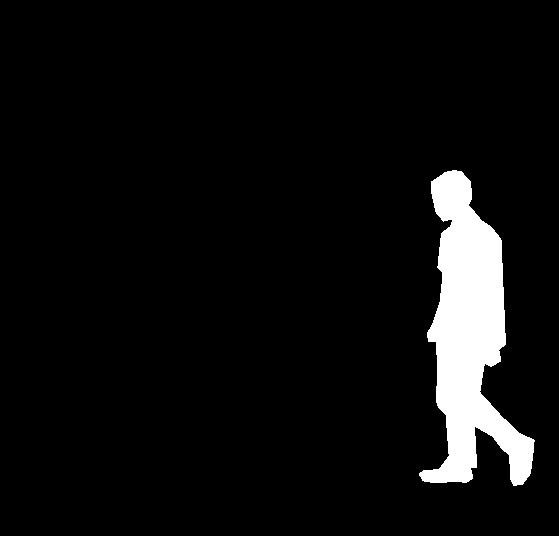

In [18]:
Image.fromarray(np.array(mask) == 2)

In [19]:
idx = 100
img = Image.open(images_path + images[idx]).convert("RGB")
mask = Image.open(masks_path + masks[idx])

In [20]:
np.unique(mask)

array([0, 1, 2, 3], dtype=uint8)

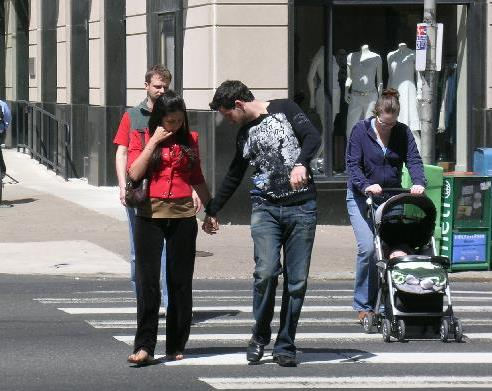

In [ ]:
img

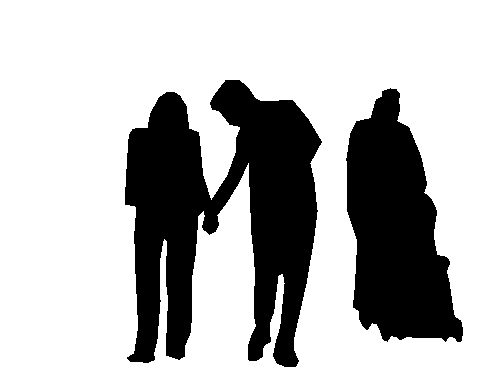

In [21]:
Image.fromarray(np.array(mask) == 0)

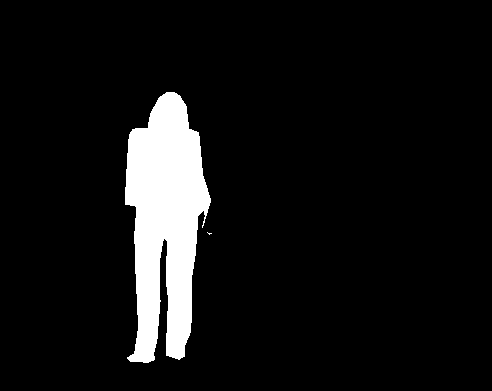

In [22]:
Image.fromarray(np.array(mask) == 1)

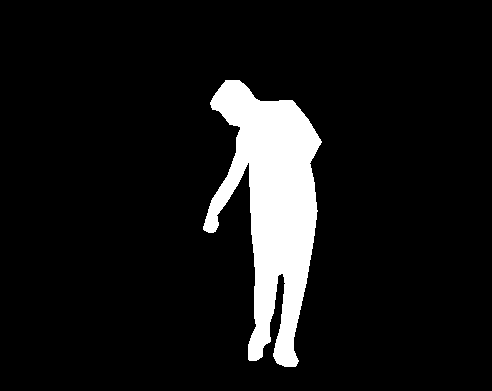

In [23]:
Image.fromarray(np.array(mask) == 2)

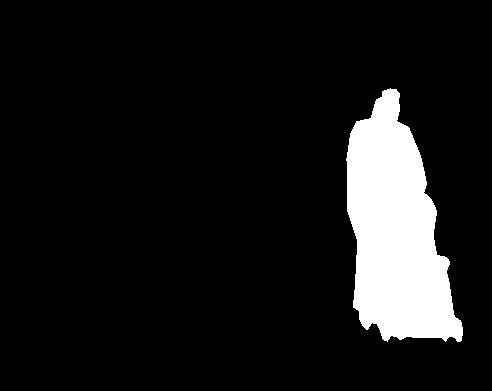

In [24]:
Image.fromarray(np.array(mask) == 3)

### Model Creation

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Mask R-CNN is a deep learning model for instance segmentation, which is the task of identifying and segmenting objects in images at the pixel level.

The model is an extension of the Faster R-CNN architecture and was introduced in a research paper titled "Mask R-CNN" by Kaiming He et al.

The torchvision.models.detection.maskrcnn_resnet50_fpn module in PyTorch provides an implementation of the Mask R-CNN model with a ResNet-50-FPN backbone. The input to the model is expected to be a list of tensors, each of shape [C, H, W], one for each image, and should be in the 0-1 range. Different images can have different sizes. The behavior of the model changes depending on whether it is in training or evaluation mode. During training, the model expects both the input tensors and a targets (list of dictionary), containing the ground-truth boxes, labels, and masks for each image.

The model returns the predicted bounding boxes, labels, scores, and masks for each image. The Mask R-CNN model is widely used for object detection and segmentation tasks in computer vision and has been applied to various applications, such as autonomous driving, robotics, and medical imaging.

In [26]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


In [27]:
model = model.to(device)

### Learning Rate

The learning rate is a hyperparameter that controls how much the model's parameters should be updated during training.

In [28]:
lr=0.005

### Optimizer

Optimizers are algorithms that adjust the model's parameters during training to minimize the loss function. Common optimizers include SGD (Stochastic Gradient Descent), Adam, and RMSprop.

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

In [30]:
def train_batch(epoch, model, optimizer, loss_history):
    print("epoch ", epoch)
    model.train()
    train_loss = 0
    step_metrics = []

    for batch_idx, batch in enumerate(train_dataloader):
        images = [batch[i][0].to(device) for i in range(len(batch))]
        targets = [batch[i][1] for i in range(len(batch))]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum([loss for loss in loss_dict.values()])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    loss_history.append(train_loss)
    print( 'Train Loss: %.3f'
                         % (train_loss/(batch_idx+1)))




In [31]:
@torch.no_grad()
def validate_batch(epoch, model, loss_history):
    global best_acc
    model.train()
    val_loss = 0
    step_metrics = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_dataloader):
            images = [batch[i][0].to(device) for i in range(len(batch))]
            targets = [batch[i][1] for i in range(len(batch))]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum([loss for loss in loss_dict.values()])

            val_loss += loss.item()

    loss_history.append(val_loss)
    print('Val Loss: %.3f'
                 % (val_loss/(batch_idx+1)))


### Training

In [32]:
start_epoch = 0
train_loss_history = []
val_loss_history = []
for epoch in range(start_epoch, start_epoch+5):
    train_batch(epoch, model, optimizer, train_loss_history)
    validate_batch(epoch, model, val_loss_history)


epoch  0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Train Loss: 1.140
Val Loss: 0.826
epoch  1
Train Loss: 0.782
Val Loss: 0.593
epoch  2
Train Loss: 0.615
Val Loss: 0.508
epoch  3
Train Loss: 0.534
Val Loss: 0.453
epoch  4
Train Loss: 0.456
Val Loss: 0.412


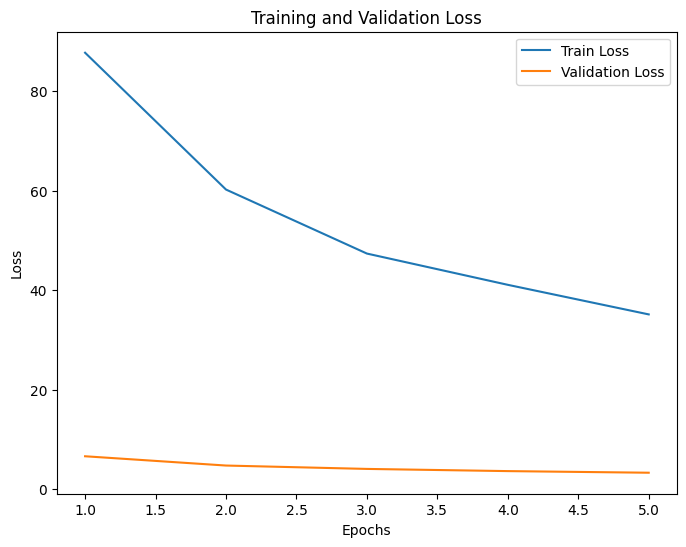

In [33]:
import matplotlib.pyplot as plt

# Plot the loss values using Matplotlib (optional)
epochs = list(range(1, len(train_loss_history) + 1))
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Plotting Ground Truth versus Prediction

[118.309395  99.430786 210.51944  321.059   ]
[181.74443   87.027245 285.9597   358.06396 ]


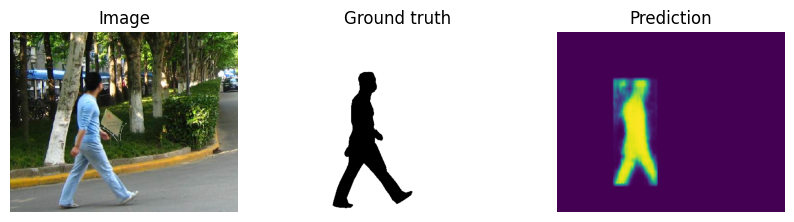

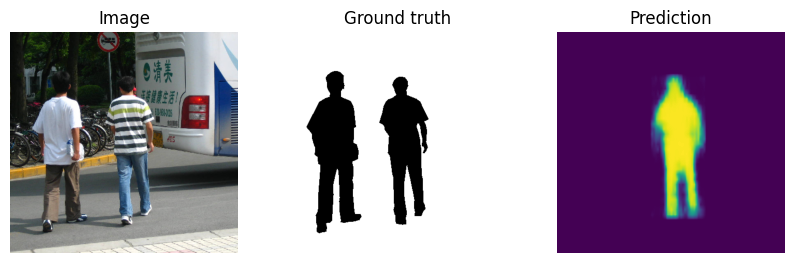

In [34]:
model.eval()
batch = next(iter(valid_dataloader))
image_batch = [batch[i][0].to(device) for i in range(len(batch))]
targets = [batch[i][1] for i in range(len(batch))]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
mask_ids = [t['image_id'] for t in targets]

with torch.no_grad():
    predictions = model(image_batch)

for idx in range(len(predictions)):
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 3, 1)
  image = image_batch[idx]
  image_transposed = torch.transpose(image, 0, 1)
  image = torch.transpose(image_transposed, 1, 2)
  plt.imshow(image.cpu())
  plt.title("Image")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  mask = Image.open(masks_path + val_masks[mask_ids[idx]])
  gt_image = Image.fromarray(np.array(mask) == 0)
  plt.imshow(gt_image) # just squeeze classes dim, because we have only one class
  plt.title("Ground truth")
  plt.axis("off")

  plt.subplot(1, 3, 3)
  plt.imshow((predictions[idx]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze())
  plt.title("Prediction")
  plt.axis("off")
  print(predictions[idx]["boxes"][0].cpu().detach().numpy())